### Predicting medical expenses

#### Load necessary libraries and dataset

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf

In [194]:
insurance = pd.read_csv("insurance.csv")

In [195]:
insurance.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [196]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [197]:
insurance['expenses'].describe()

count     1338.000000
mean     13270.422414
std      12110.011240
min       1121.870000
25%       4740.287500
50%       9382.030000
75%      16639.915000
max      63770.430000
Name: expenses, dtype: float64

###### Here mean is greater than median, so we can tell that the distribution of expenses is right skewed

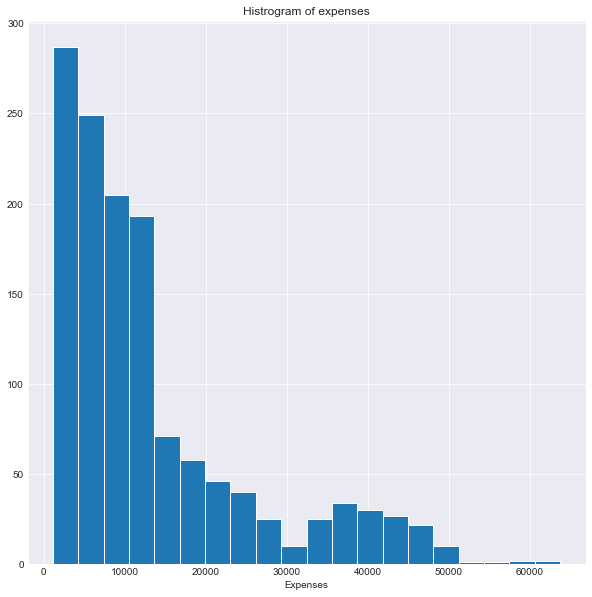

In [198]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(insurance['expenses'], bins=20)
ax.set(title = "Histrogram of expenses", xlabel = "Expenses")
plt.show()

In [199]:
insurance.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

#### Exploring relationships among features

In [200]:
# Correlation matrix
insurance[['age','bmi', 'children', 'expenses']].corr()

,age,bmi,children,expenses
age,1.000000,0.109341,0.042469,0.299008
bmi,0.109341,1.000000,0.012645,0.198576
children,0.042469,0.012645,1.000000,0.067998
expenses,0.299008,0.198576,0.067998,1.000000


In [201]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

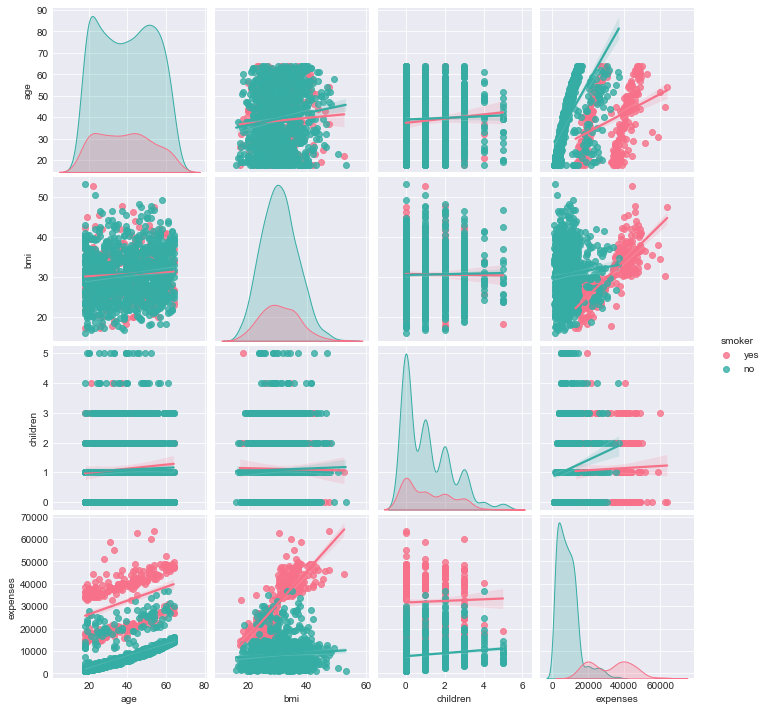

In [202]:
#plt.style.use('seaborn-whitegrid')
sns.set_style('darkgrid')
sns.pairplot(insurance, diag_kind='kde', kind='reg', hue='smoker',  palette="husl", );

###### Training a model on the data

In [203]:
# Before training the model, lets try to know some information about model through stat model
ins_stat_model = smf.ols('expenses ~ age + sex + bmi + children + smoker + region', data=insurance).fit()
print(ins_stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.9
Date:                Sat, 20 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:02:17   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.194e+04    

In [204]:
# Transform the categorical data for the model
insurance['smoker'] = insurance['smoker'].map({'no': 0, 'yes': 1})
insurance['region'] = insurance['region'].map({'southeast': 0, 'southwest': 1, 'northwest': 2, 'northeast': 3})

In [205]:
insurance['region'].value_counts()

0    364
1    325
2    325
3    324
Name: region, dtype: int64

In [206]:
# We set feature x and target y as the combination of important variables according to OLS Regression Results
X = insurance[['age', 'bmi', 'children', 'smoker', 'region']]
y = insurance['expenses']

In [207]:
# Now we will keep 25% data for test and train the model with the remaining data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

#### Evaluate the model performance

In [208]:
ins_model = LinearRegression()
ins_model.fit(X_train, y_train)

LinearRegression()

In [209]:
y_preds = ins_model.predict(X_test)

In [210]:
# Check the accuracy and r2 score
accuracy = ins_model.score(X_test, y_test)
print("Accuracy :", accuracy*100)
print("R2:", r2_score(y_test, y_preds))

Accuracy : 76.34676532746825
R2: 0.7634676532746825


###### We see that this model was able to predict about 76.35% accuracy

In [211]:
# Compare the train set accurcy with test accuracy
print("Train set accurcy: ", r2_score(y_train, ins_model.predict(X_train)))
print("Test set accurcy: ", r2_score(y_test, y_preds))

Train set accurcy:  0.745858296621303
Test set accurcy:  0.7634676532746825


### Improving model performance

* Added a non-linear term for age
* Created an indicator for obesity
* Specified an interaction between obesity and smoking

In [212]:
# Model specification – adding non-linear relationships
insurance['age2'] = insurance['age']**2

In [213]:
# Transformation – converting a numeric variable to a binary indicator
insurance['bmi30'] = insurance['bmi'].apply(lambda x: 1 if x>=30 else 0)

In [214]:
# apply OLS Regression with interaction effects
ins_model2 = smf.ols('expenses ~ age + age2 + sex + bmi + children + smoker*bmi30 + region', data=insurance).fit()

In [215]:
print(ins_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     952.5
Date:                Sat, 20 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:02:33   Log-Likelihood:                -13134.
No. Observations:                1338   AIC:                         2.629e+04
Df Residuals:                    1328   BIC:                         2.634e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1080.7949   1392.003     -0.776   

In [216]:
X = insurance[['age2', 'sex', 'bmi', 'bmi30', 'children', 'smoker', 'region']]
y = insurance['expenses']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [218]:
from sklearn.preprocessing import PolynomialFeatures
pf  = PolynomialFeatures(interaction_only=True)
X_ = pf.fit_transform(X)
X_test_ = pf.fit_transform(X_test)

ValueError: could not convert string to float: 'female'

In [ ]:
## Interaction effect with polynomial regression need to study more than the improvment will be done.